# stackalign – Aligning a Stack of Images Based On a Fixed Target Outline

Authors: Daniel Sieber, Samuel John

#### Abstract

Images that have been cut or grinded from a block are oftentimes not aligned. This IPython notebook uses a fixed target structure in the image (in our case the outline of an overmold) that is visible in all images of the stack to find the best affine transform which aligns all images to the given target. The target is based on one image of the stack where only the fixed structure remains visible and the remaining area is made transparent.

#### Repository

<https://github.com/awesomecodingskills/reconstruct_volume_from_RGB_slices>

#### TODO

- Write better Abstract
- Add "How to cite" statement and link to paper (DOI) here
- Improve code commenting


#### [The MIT License (MIT)](http://opensource.org/licenses/MIT)

Copyright (c) 2015-2017 Daniel Sieber, Samuel John


<div style="font-size:7pt;">
Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT.  IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
THE SOFTWARE.
</div>

### Imports & Set-Up

In [1]:
# Plot in this IPython Notebook instead of opening separate windows
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import logging
from xml.dom import minidom
import svg.path  # you might need to `pip install svg.path`

In [3]:
from .stackalign import plot_overlay

ModuleNotFoundError: No module named '__main__.stackalign'; '__main__' is not a package

### Start of main script

In [14]:
# Load Target File containing the template for the further template matching
target = img_as_float(io.imread("/Users/sam/HoerSys/HS03_External_Projects/RESPONSE_tube_2018_Lena/50-016_links_template-083.png"))

# Load SVG file containing outline of template and extract path frpom xml format
svg_xml = minidom.parse("/Users/sam/HoerSys/HS03_External_Projects/RESPONSE_tube_2018_Lena/50-016_links_template-083.svg")
svg_path = svg.path.parse_path([path.getAttribute('d') for path in svg_xml.getElementsByTagName('path')][0])
svg_xml.unlink()

# Load image collection
ic = io.ImageCollection('./Probe Felsenbein links/*.tif:./Probe Felsenbein links/*.jpg',conserve_memory=True)
#ic = io.ImageCollection('./test_image.tif')
# Assure the border of the target is transparent
target[0,:,3] = 0.0
target[-1,:,3] = 0.0
target[:,0,3] = 0.0
target[:,-1,3] = 0.0

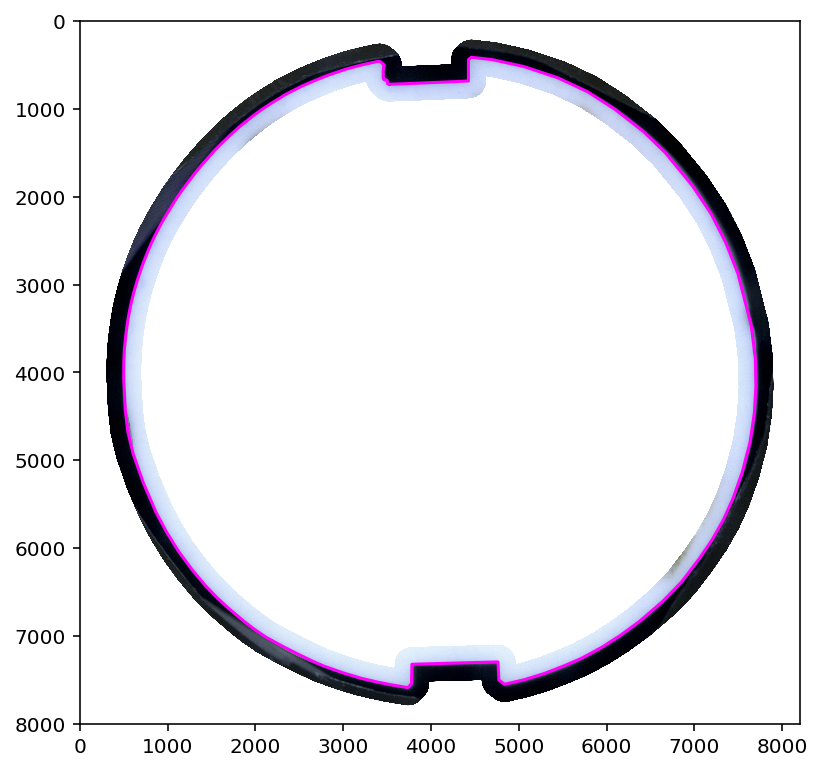

In [15]:
#Quick check if the target image and the SVG outline match
overlay = plot_overlay(target, svg_path, figsize=(5,5))
del overlay

In [16]:
#Definition of search strategy for brute force
rough_search_strategy = [dict(rescale=0.02, angle_range=(0,0,1), roi_hw=(211,211)),
                         dict(rescale=0.08, angle_range=(-25,  25,  62), roi_hw=(61, 61)),
                         dict(rescale=0.1, angle_range=(-3,  3,  32), roi_hw=(161, 161)),
                         dict(rescale=0.15, angle_range=(-0.5,  0.5,  32), roi_hw=(41, 41)),
                         dict(rescale=0.2, angle_range=(-0.1,  .1,  22), roi_hw=(21, 21)),
                      ]


fine_search_strategy = []
# fine_search_strategy = [dict(rescale=0.2, tol=120.0)]

In [17]:
import warnings

Skipping (already processed) image Nr. 0 - ./Probe Felsenbein links/001.jpg
Skipping (already processed) image Nr. 1 - ./Probe Felsenbein links/002.tif
Skipping (already processed) image Nr. 2 - ./Probe Felsenbein links/003.tif
Skipping (already processed) image Nr. 3 - ./Probe Felsenbein links/004.tif
Skipping (already processed) image Nr. 4 - ./Probe Felsenbein links/005.tif
Skipping (already processed) image Nr. 5 - ./Probe Felsenbein links/006.tif
Skipping (already processed) image Nr. 6 - ./Probe Felsenbein links/007.tif
Skipping (already processed) image Nr. 7 - ./Probe Felsenbein links/008.tif
Skipping (already processed) image Nr. 8 - ./Probe Felsenbein links/009.tif
Skipping (already processed) image Nr. 9 - ./Probe Felsenbein links/010.tif
Skipping (already processed) image Nr. 10 - ./Probe Felsenbein links/011.tif
Skipping (already processed) image Nr. 11 - ./Probe Felsenbein links/012.tif
Skipping (already processed) image Nr. 12 - ./Probe Felsenbein links/013.tif
Skipping 

Skipping (already processed) image Nr. 100 - ./Probe Felsenbein links/101.tif
Skipping (already processed) image Nr. 101 - ./Probe Felsenbein links/102.tif
Skipping (already processed) image Nr. 102 - ./Probe Felsenbein links/103.tif


Image Nr. 103 - ./Probe Felsenbein links/104.tif

 === BRUTE FORCE ALIGNMENT ===


KeyboardInterrupt: 

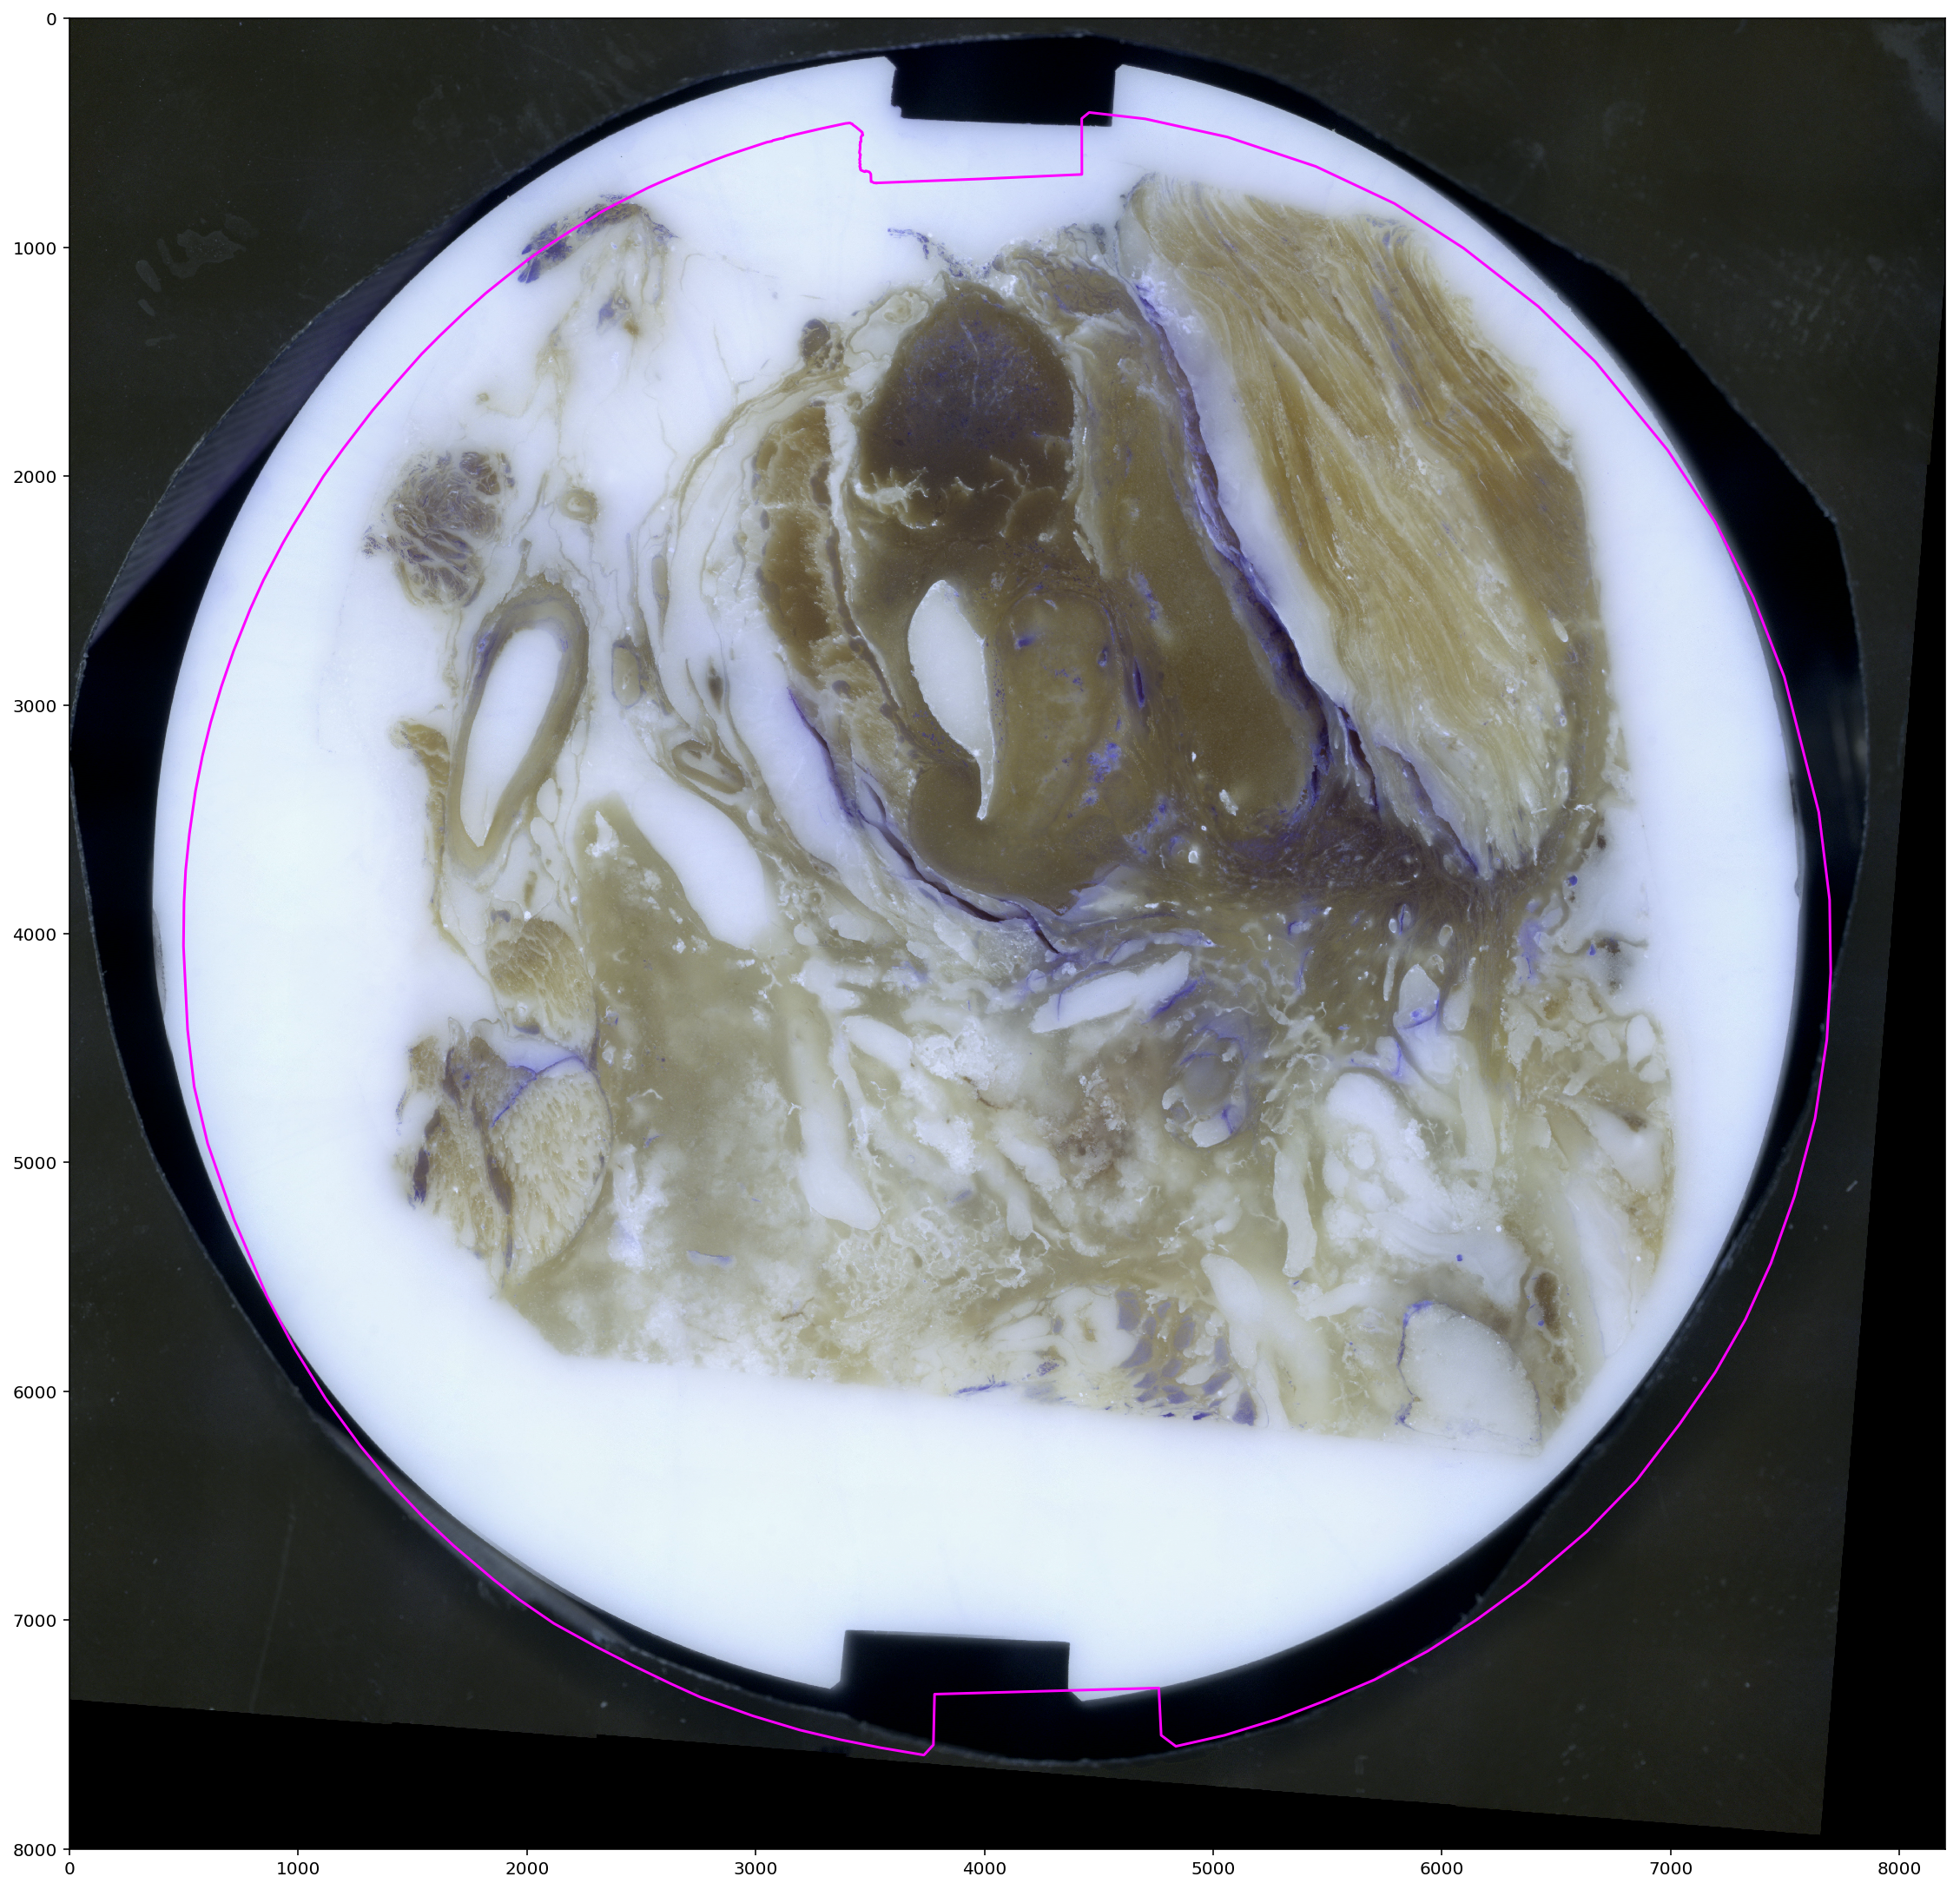

In [18]:
#Execution of image alignment
with warnings.catch_warnings():
    PF=pattern_finder_gpu.PatternFinder(partitions=10)
    PF.logger.setLevel(logging.INFO)
    warnings.simplefilter("ignore")  # strangely "once" does not seem to do what it says... so for now just "shut up"
    result = build_stack(ic[:],
                         target,
                         rough_search_strategy=rough_search_strategy,
                         fine_search_strategy=fine_search_strategy,
                         PF=PF,
                         write_files='./EXPORT',
                         plot=False)